In [12]:
import os
import torchvision
# import utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython import display
from PIL import Image
import pandas as pd
import shutil
import evals.embed_evals as evals
import models.utils as utils
from sklearn.linear_model import LogisticRegression
import pickle
import plot_data as plot
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
try:
    a=2
    assert(False)
except:
    print(1)
    print(a)

1
2


In [16]:
err = evals.get_NI(RESN_train_50 , y_train, RESN_test_50, y_test)[10]

In [17]:
err

28

In [33]:
[] is None

False

TSNEing


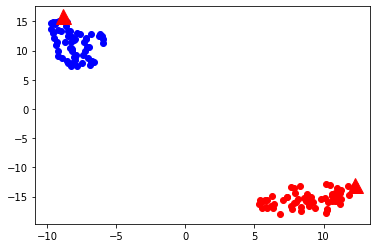

In [28]:
x_all = np.concatenate([RESN_train_50, [RESN_test_50[10]]])
x_train = plot.tsne2(x_all)
classes = np.unique(y_train)
colors = {1:'b',0:'r'}

for c in classes:
    c_idx = np.where(y_train==c)[0]
    plt.scatter(x_train[c_idx][:,0], x_train[c_idx][:,1], c=colors[c])
test = x_train[-1]
t1 = x_train[28]
plt.plot(test[0], test[1], marker='^',  markersize=15,c=colors[y_test[10]])
plt.plot(t1[0], t1[1], marker='^',  markersize=15, c=colors[y_train[28]])

# wv_2d

In [ ]:
def return_label(w,b,x,y): return 1 if y > w*x+b else  0
w = -0.73027025
b = 0.68565111

In [ ]:
df = evals.get_wv_df()
selected_features = ["bodyheadszratio","bodyheadcolordiff"]
df['pseudo_label'] = df.apply(lambda row : return_label(w,b,row[selected_features[0]],row[selected_features[1]]), axis = 1)
df


In [ ]:
p2i_train = pickle.load(open("/net/scratch/chacha-shared/weevil_vespula/p2i.pkl","rb"))
i2p_train = {v:k for k,v in p2i_train.items()}
p2i_test = pickle.load(open("/net/scratch/chacha-shared/weevil_vespula/p2i_test.pkl","rb"))
i2p_test = {v:k for k,v in p2i_test.items()}
df_train = df.iloc[[int(x) for x in p2i_train.keys()]]

In [ ]:
def vis_err_df(df, err):
#     plt.figure(figsize=(8,6))
    colors = {1:'b',0:'r'}

    plt.scatter(df_train[selected_features[0]],df_train[selected_features[1]], c=df_train['pseudo_label'], s=50,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)

    a_label, p_label, n_label = df.iloc[int(i2p_test[err[0]])]["pseudo_label"], df.iloc[int(i2p_train[err[1]])]["pseudo_label"], df.iloc[int(i2p_train[err[2]])]["pseudo_label"]
    a = df.iloc[int(i2p_test[err[0]])][selected_features].values
    p = df.iloc[int(i2p_train[err[1]])][selected_features].values
    n = df.iloc[int(i2p_train[err[2]])][selected_features].values
    plt.scatter(a[0],a[1], edgecolors=colors[a_label], marker='^', s=500, linewidths=1, c="w")
    plt.scatter(p[0],p[1], edgecolors=colors[p_label], marker='^', s=500, linewidths=1, c="w")
    plt.scatter(n[0],n[1], edgecolors=colors[n_label], marker='^', s=500, linewidths=1, c="w")
    plt.plot(a[0],a[1],  c=colors[a_label], marker='$A$', markersize=15)
    plt.plot(p[0],p[1], c=colors[p_label], marker='$P$', markersize=15)
    plt.plot(n[0],n[1], c=colors[n_label], marker='$N$', markersize=15)

    plt.show()

In [ ]:
RESN_errors = [[1, 35, 105], [2, 35, 105], [3, 35, 105], [9, 35, 105], [10, 35, 105], [12, 35, 105], [13, 35, 105], [15, 42, 105], [29, 35, 105], [39, 35, 105]]
TN_errors = [[1, 23, 96], [3, 19, 100], [10, 10, 86], [13, 28, 115], [22, 27, 62], [23, 28, 68], [26, 10, 103], [27, 11, 77], [29, 45, 101], [32, 7, 108], [33, 27, 107], [36, 5, 113], [37, 52, 82], [39, 1, 101]]
MTL_errors = [[10, 10, 86], [12, 15, 97], [22, 27, 69], [23, 28, 102], [25, 27, 107], [26, 10, 103], [29, 42, 101], [32, 25, 108], [34, 59, 71], [36, 5, 113], [37, 27, 111], [38, 59, 73], [39, 35, 101]]
# MTL_errors = [[3, 49, 100], [10, 10, 86], [13, 56, 68], [21, 27, 80], [22, 27, 62], [23, 28, 117], [26, 10, 103], [27, 11, 108], [28, 52, 98], [29, 55, 101], [31, 10, 66], [32, 7, 108], [33, 27, 67], [34, 30, 89], [36, 5, 113], [37, 27, 80], [38, 30, 89], [39, 1, 101]]

In [ ]:
RESN_TN = [err for err in RESN_errors if err in TN_errors]
RESN_MTL = [err for err in RESN_errors if err in MTL_errors]
TN_MTL = [err for err in TN_errors if err in MTL_errors]
len(RESN_TN), len(RESN_MTL), len(TN_MTL)

## vis on input space

In [ ]:
for err in RESN_errors[:4]: vis_err_df(df, err)

In [ ]:
for err in TN_MTL: vis_err_df(df, err)

In [ ]:
for err in TN_errors[:4]: 
    if err not in TN_MTL: vis_err_df(df, err)

In [ ]:
for err in MTL_errors[:4]: 
    if err not in TN_MTL: vis_err_df(df, err)

## vis on embedding space

In [ ]:
y_train = torchvision.datasets.ImageFolder("data/weevil_vespula/train")
y_train = [x[1] for x in y_train]
RESN_train = pickle.load(open("embeds/wv_2d/pretrained/RESN_train_emb512.pkl","rb"))
TN_train = pickle.load(open("embeds/wv_2d/pretrained/TN_train_emb512.pkl","rb"))
MTL_train = pickle.load(open("embeds/wv_2d/pretrained/MTL_train_emb512.pkl","rb"))

In [ ]:
y_test = torchvision.datasets.ImageFolder("data/weevil_vespula/test")
y_test = [x[1] for x in y_test]
RESN_test = pickle.load(open("embeds/wv_2d/pretrained/RESN_test_emb512.pkl","rb"))
TN_test = pickle.load(open("embeds/wv_2d/pretrained/TN_test_emb512.pkl","rb"))
MTL_test = pickle.load(open("embeds/wv_2d/pretrained/MTL_test_emb512.pkl","rb"))

In [ ]:
def vis_err_embeds(x_train, y_train, x_test, y_test, err):
    plt.figure(figsize=(8,6))
    colors = {1:'b',0:'r'}
    x_test = [x_test[err[0]]]
    y_test = [y_test[err[0]]]
    x_all = plot.tsne2(np.concatenate([x_train,x_test]))
    y_all = y_train + y_test
    x_train = x_all[np.arange(len(x_train))]
    x_test = x_all[np.arange(len(x_train),len(x_train)+len(x_test))]

    classes = np.unique(y_all)

    for c in classes:
        c_idx = np.where(y_train==c)[0]
        plt.scatter(x_train[c_idx][:,0], x_train[c_idx][:,1], c=colors[c])

    a,p,n = err[0], err[1], err[2]
    a_label, p_label, n_label = y_test[0], y_train[p], y_train[n]
    plt.scatter(x_test[0][0], x_test[0][1], edgecolors=colors[a_label], marker='^', s=500, linewidths=1, c="w")
    plt.scatter(x_train[p][0], x_train[p][1], edgecolors=colors[p_label], marker='^', s=500, linewidths=1, c="w")
    plt.scatter(x_train[n][0], x_train[n][1], edgecolors=colors[n_label], marker='^', s=500, linewidths=1, c="w")
    plt.plot(x_test[0][0], x_test[0][1], c=colors[a_label], marker='$A$',markersize=15)
    plt.plot(x_train[p][0], x_train[p][1], c=colors[p_label], marker='$P$',markersize=15)
    plt.plot(x_train[n][0], x_train[n][1], c=colors[n_label], marker='$N$',markersize=15)

    plt.show()
    return x_train,x_test

In [ ]:
RESN_train_2, RESN_test_2 = vis_err_embeds(RESN_train, y_train, RESN_test, y_test, RESN_errors[0])

In [ ]:
TN_train_2, TN_test_2 = vis_err_embeds(TN_train, y_train, TN_test, y_test, TN_errors[0])

In [ ]:
MTL_train_2, MTL_test_2 = vis_err_embeds(MTL_train, y_train, MTL_test, y_test, MTL_errors[0])

In [ ]:
MTL_errors_10 = [[1, 30, 96], [2, 52, 79], [3, 19, 89], [9, 23, 96], [10, 10, 86], [13, 28, 115], [15, 14, 101], [21, 27, 111], [22, 27, 107], [23, 28, 68], [27, 43, 108], [29, 12, 101], [32, 43, 108], [33, 27, 107], [34, 30, 73], [37, 52, 82], [39, 1, 101]]
RESN_errors_10 = [[2, 47, 86], [10, 41, 86], [13, 41, 86], [24, 41, 114], [27, 41, 74], [29, 41, 86], [30, 41, 61], [34, 41, 86], [36, 41, 61], [38, 41, 66], [39, 41, 86]]
[err for err in RESN_errors_10 if err in MTL_errors_10]

In [67]:
y_train = torchvision.datasets.ImageFolder("data/weevil_vespula/train")
y_train = [x[1] for x in y_train]
y_test = torchvision.datasets.ImageFolder("data/weevil_vespula/test")
y_test = [x[1] for x in y_test]
MTL_train_10 = pickle.load(open("embeds/wv_2d/pretrained/MTL_train_emb10.pkl","rb"))
MTL_test_10 = pickle.load(open("embeds/wv_2d/pretrained/MTL_test_emb10.pkl","rb"))
RESN_train_10 = pickle.load(open("embeds/wv_2d/pretrained/RESN_train_emb10.pkl","rb"))
RESN_test_10 = pickle.load(open("embeds/wv_2d/pretrained/RESN_test_emb10.pkl","rb"))

In [ ]:
RESN_train_2, RESN_test_2 = vis_err_embeds(RESN_train_10, y_train, RESN_test_10, y_test, RESN_errors_10[0])

In [ ]:
MTL_train_2, MTL_test_2 = vis_err_embeds(MTL_train_10, y_train, MTL_test_10, y_test, MTL_errors_10[0])

In [2]:
y_train = torchvision.datasets.ImageFolder("data/weevil_vespula/train")
y_train = [x[1] for x in y_train]
y_test = torchvision.datasets.ImageFolder("data/weevil_vespula/test")
y_test = [x[1] for x in y_test]
RESN_train_50 = pickle.load(open("embeds/wv_2d/pretrained/RESN_train_emb50.pkl","rb"))
RESN_test_50 = pickle.load(open("embeds/wv_2d/pretrained/RESN_test_emb50.pkl","rb"))

In [70]:

def NIFO(x_train, y_train, x, y):
    ''' for each test example, return its in-class nearest neighbors and out-of-classes farthest "neighbor", for all classes '''
    classes = np.unique(y_train)
    idx_by_class = {c: np.where(y_train==c)[0] for c in classes}
    # print(idx_by_class)

    example = []
    for c in classes:
        in_class = x_train[idx_by_class[c]]
        dists = np.array([evals.euc_dist(x, x_) for x_ in in_class])
        # print(dists)
        # print(dists[30], dists[33])
        class_nn = np.argmin(dists)# if y == c else np.argmax(dists)
        class_nn = idx_by_class[c][class_nn]
        example.append(class_nn)

    return example

In [78]:
MTL_errors_10[0]

[1, 30, 96]

In [71]:
x = MTL_test_10[MTL_errors_10[0][0]]
y = y_test[MTL_errors_10[0][0]]
NIFO(MTL_train_10, y_train, x,y)

[30, 96]

In [86]:
evals.get_rational_NINO(MTL_train_10, y_train, MTL_test_10,y_test)

array([[ 22, 101],
       [ 30,  73],
       [ 52, 116],
       [ 19,  89],
       [ 38, 101],
       [ 22, 101],
       [ 39, 101],
       [  6, 101],
       [ 38, 101],
       [ 23,  96],
       [ 10,  64],
       [ 22, 101],
       [ 40, 105],
       [ 28, 104],
       [  2, 101],
       [ 14, 101],
       [ 13, 101],
       [ 54, 101],
       [ 45, 101],
       [ 35, 101],
       [112,  10],
       [111,  27],
       [107,  27],
       [ 68,  28],
       [ 84,  53],
       [104,  27],
       [ 81,  10],
       [108,  43],
       [118,  52],
       [101,  26],
       [ 94,  30],
       [ 69,  27],
       [108,  43],
       [107,  27],
       [ 73,  30],
       [106,  10],
       [ 94,  19],
       [ 82,  52],
       [ 96,  30],
       [101,   2]])

In [85]:
evals.get_NINO(MTL_train_10, y_train, MTL_test_10,y_test)

array([[ 22, 101],
       [ 30,  96],
       [ 52,  79],
       [ 19,  89],
       [ 38, 101],
       [ 22, 101],
       [ 39, 101],
       [  6, 101],
       [ 38, 101],
       [ 23,  96],
       [ 10,  86],
       [ 22, 101],
       [ 40, 105],
       [ 28, 115],
       [  2, 101],
       [ 14, 101],
       [ 13, 101],
       [ 54, 101],
       [ 45, 101],
       [ 35, 101],
       [112,  10],
       [111,  27],
       [107,  27],
       [ 68,  28],
       [ 84,  53],
       [104,  27],
       [ 81,  10],
       [108,  43],
       [118,  52],
       [101,  12],
       [ 94,  30],
       [ 69,  27],
       [108,  43],
       [107,  27],
       [ 73,  30],
       [106,  10],
       [ 94,  19],
       [ 82,  52],
       [ 96,  30],
       [101,   1]])

In [83]:
np.where(a>1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),)

## Generate new decision boundary

In [ ]:
def pseudo_label(w, b, row, selected_features):
    x = np.array(row[selected_features[0]])
    y = np.array(row[selected_features[1]])
    y_prime = w*x+b

    if y > y_prime: return 1
    else: return 0


def pseudo_label_2feat(clf, row, selected_features):
    b = clf.intercept_[0]
    w1, w2 = clf.coef_.T
    b = -b/w2
    w1 = -w1/w2

    x = np.array(row[selected_features[0]])
    y = np.array(row[selected_features[1]])
    y_prime = w1*x+b

    if y > y_prime: return 1
    else: return 0
    
def pseudo_label_4fea(clf,x1,x2,x3,x4):
    w1, w2, w3, w4 = clf.coef_.T
    b = clf.intercept_[0]

    b = -b/w4
    w1 = -w1/w4
    w2 = -w2/w4
    w3 = -w3/w4
    ws = np.squeeze(np.array([w1,w2,w3]))
    xs = np.array([x1,x2,x3])
    l_prime = np.dot(ws,xs)+b
    if x4 > l_prime: return 1
    else: return 0

# df["pseudo_label"] = df.apply(lambda row : pseudo_label_4fea(clf, row[selected_features[0]],row[selected_features[1]],row[selected_features[2]],row[selected_features[3]]), axis = 1)
# plot_3d(df, selected_features, clf, "pseudo_label")

def plot_2feat(df, selected_features, clf, label="label"):
    b = clf.intercept_[0]
    w1, w2 = clf.coef_.T
    b = -b/w2
    w1 = -w1/w2

    min_x = min(df[selected_features[0]])
    max_x = max(df[selected_features[0]])
    xd = np.array([min_x,max_x])
    yd = w1*xd + b
    plt.plot(xd, yd, 'k', lw=3, ls='--')
    plt.scatter(df[selected_features[0]],df[selected_features[1]], c=df[label], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

    plt.ylabel(selected_features[1])
    plt.xlabel(selected_features[0])
    plt.show()

def plot_3d(df, selected_features, clf, label="label"):
    b = clf.intercept_[0]
    w1, w2, w3 = clf.coef_.T
    b = -b/w3
    w2 = -w2/w3
    w1 = -w1/w3
    X = np.linspace(-2,2,100)
    Y = np.linspace(-2,2,100)
    X, Y = np.meshgrid(X, Y)
    Z = w1*X + w2*Y + b
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(projection='3d')
    ax.view_init(10, 30)
    colors = ["r","g"]
    for i in range(len(df)):
        ax.scatter(df[selected_features[0]][i], df[selected_features[1]][i], df[selected_features[2]][i], c=colors[df[label][i]])
    ax.plot_surface(X, Y, Z, alpha=0.5)
    plt.show()

In [ ]:
df = pd.read_csv("/net/scratch/tianh-shared/wv_3d/data.csv")
selected_features = ["head size","body size"]
# clf = LogisticRegression().fit(df[selected_features],df['label'])
# df['pseudo_label'] = df.apply(lambda row : pseudo_label_2feat(clf,row, selected_features), axis = 1)
# plot_2feat(df, selected_features, clf,"pseudo_label")

In [ ]:
colors=["r","g"]
for i in range(len(df)):
    plt.scatter(df[selected_features[0]][i], df[selected_features[1]][i], c=colors[df["label"][i]])

In [ ]:
w1 = -1
b = 0

min_x = min(df[selected_features[0]])
max_x = max(df[selected_features[0]])
xd = np.array([min_x,max_x])
yd = w1*xd + b
plt.plot(xd, yd, 'k', lw=3, ls='--')
plt.scatter(df[selected_features[0]],df[selected_features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)

plt.ylabel(selected_features[1])
plt.xlabel(selected_features[0])
plt.show()

In [ ]:
df['pseudo_label'] = df.apply(lambda row : pseudo_label(w1, b, row, selected_features), axis = 1)

In [ ]:
for i in range(len(df)):
    c = str(df.iloc[i]["pseudo_label"])
    img = df.iloc[i]["img_id"]
    src = os.path.join("/net/scratch/tianh-shared/wv_3d/imgs",img)
    dst = os.path.join("/net/scratch/tianh-shared/wv_3d/2feats",c)
    shutil.copy(src, dst) 

In [ ]:
"0.png"[:-4]

In [ ]:
df

In [ ]:
data_dir = "/net/scratch/tianh-shared/wv_3d/2feats/auto_split"
for split in ["train","valid","test"]:
    split_dir = os.path.join(data_dir, split)
    split_imgs = utils.dataset_filenames(split_dir)[:,0]
    split_imgs = [int(x.split("/")[-1][:-4]) for x in split_imgs]
    print(split_imgs)
    break

## Human distorted space

In [ ]:
test = np.random.choice(np.arange(len(df)), int(len(df)*0.2), replace=False)
train = np.setdiff1d(np.arange(len(df)), test)
train_df = df.iloc[train]
test_df = df.iloc[test]

In [ ]:
selected_features = ["head size","body size", "tail size", "texture"]
train_x = np.array(train_df[selected_features])
train_y = np.array(train_df["pseudo_label"])
test_x = np.array(test_df[selected_features])
test_y = np.array(test_df["pseudo_label"])

In [ ]:
evals.distorted_1nn(train_x, train_y, test_x, test_y, [1,1,0,0], [2,2,2,2])

In [ ]:
evals.distorted_1nn(train_x, train_y, test_x, test_y, [0, 1, 1, 10000], [2,2,2,2])

In [ ]:
scores = []
weights = list(itertools.product([0, 1], repeat=4))[1:]
scores = [evals.distorted_1nn(train_x, train_y, test_x, test_y, w, [2,2,2,2]) for w in weights]
df_search = pd.DataFrame({'weights': weights, "scores":scores})
df_search

In [ ]:
scores = []
weights = list(itertools.product([0, 1], repeat=4))[1:]
scores = [evals.distorted_1nn(train_x, train_y, test_x, test_y, w, [1,1,1,1]) for w in weights]
df_search = pd.DataFrame({'weights': weights, "scores":scores})
df_search

In [ ]:
train_x[0]

In [ ]:
evals.weightedPdist(train_x[0], train_x[1], [0,0,0,0],[2,2,2,2])

In [ ]:
w_cands = [-10000, -100, -1, 0, 1, 100, 10000, 0, 0,0,0]
weights = []
scores = []
for _ in range(1000):
    w = [random.choice(w_cands) for _ in range(4)]
    score = evals.distorted_1nn(train_x, train_y, test_x, test_y, w, [2,2,2,2])
    scores.append(score)
    weights.append(w)
df_search = pd.DataFrame({'weights': weights, "scores":scores})
df_search.to_csv("search.csv",index=False)

In [ ]:
visual_weights = [2.73027025, 1]
w = -0.73027025
b = 0.68565111
xd = np.array([0, 1])
yd = w*xd + b
# plt.plot(xd, yd, 'k', lw=1, ls='--')
# plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.scatter(df[selected_features[0]]*np.sqrt(2.73027025),df[selected_features[1]], c=df['pseudo_label'], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)

plt.xlim(0, 1.4)
plt.ylim(0, 0.7)
# plt.ylim(ymin, ymax)
plt.ylabel(selected_features[1])
plt.xlabel(selected_features[0]+'--distorted')
plt.show()
